In [1]:
import numpy as np
import pandas
import pylab as plt  # matplotlib的一个子包
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from keras.models import load_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error # 平方绝对误差
from sklearn.metrics import r2_score  # R square

import sys 
sys.path.append(r'C:\\Users\\demo\\workplace\\Time-Series-Prediction-with-LSTM\\')  # 要用绝对路径
from utils import eemd_tools, data_tools, networks_factory, data_metrics
from utils.constants import const

Using TensorFlow backend.


# 导入数据

In [2]:
data_multi = np.load(const.PROJECT_DIR + "data/eemd/apple/data_multi.npy")
print("# shape", data_multi.shape)  # not .shape()

# shape (1901, 4)


## data preprocessing

In [3]:
# normalize features
scaler = data_tools.Ne_MinMaxScaler
scaled = scaler.fit_transform(data_multi)

output = 1
lag = 13

reframed = data_tools.series_to_supervised(scaled, lag, output)
# drop columns we don't want to predict
index_drop = [-j-1 for j in range(data_multi.shape[1] - 1)]
reframed.drop(reframed.columns[index_drop], axis=1, inplace=True)
data_supervised = reframed.values
print("# shape:", reframed.shape)
print(len(data_multi) == len(reframed) + lag)
# print(reframed.head(3))

# split into train and test sets
train_size = int(len(data_supervised) * const.TRAIN_SCALE)
test_size = len(data_supervised) - train_size
train_data, test_data = data_supervised[0:train_size,:], data_supervised[train_size:len(data_multi),:]
print(len(train_data), len(test_data))
print(len(data_supervised) == len(train_data) + len(test_data)) 
# print(train_data)

# shape: (1888, 53)
True
1510 378
True


In [4]:
# split into input and outputs
train_X, train_Y = train_data[:, :-1], train_data[:, -1]
test_X, test_Y = test_data[:, :-1], test_data[:, -1]
print("# shape:", train_X.shape)
print("# shape:", test_X.shape)

# shape: (1510, 52)
# shape: (378, 52)


# Networks

In [5]:
n_epoch = networks_factory.EPOCHS
n_batch_size = networks_factory.BATCH_SIZE
n_hidden_neurons = networks_factory.HIDDEN_NEURONS

# BP: validation_data=(test_X, test_Y)

In [6]:
n_dims = train_X.shape[1]  # magic number !
# create model
s, model = networks_factory.create_bp_model(hidden_neurons=n_hidden_neurons, dims=n_dims, n_out=1)
# Compile model
model.compile(loss='mean_squared_error', optimizer='adam')  # notice: Classification problem and regression problem
# Fit the model
print("-----------neural_nets_flag: BP--------------")
history = model.fit(train_X, train_Y, epochs=n_epoch, batch_size=n_batch_size, validation_data=(test_X, test_Y), 
                    verbose=0, callbacks=[networks_factory.ES]) 
print("# Finished Training...")

-----------neural_nets_flag: BP--------------
Epoch 00390: early stopping
# Finished Training...


In [7]:
# make a prediction
train_predict = model.predict(train_X)
test_predict = model.predict(test_X)

time_steps = lag  # for the same uniform interface of inv_transform_multi()
# reshape input to be 3D [samples, timesteps, features]
temp_train_X = train_X.reshape((train_X.shape[0], time_steps, train_X.shape[1]//time_steps))
temp_test_X = test_X.reshape((test_X.shape[0], time_steps, test_X.shape[1]//time_steps))

# invert predictions
inv_trainP, inv_trainY = data_tools.inv_transform_multi(scaler, temp_train_X, train_predict, train_Y)
inv_testP, inv_testY = data_tools.inv_transform_multi(scaler, temp_test_X, test_predict, test_Y)

# calculate RMSE, MAPE, Dstat
train_rmse = sqrt(mean_squared_error(inv_trainP, inv_trainY))
test_rmse = sqrt(mean_squared_error(inv_testP, inv_testY))
print('Train RMSE: %.4f, Test RMSE: %.4f' % (train_rmse, test_rmse))
train_mape = data_metrics.MAPE(inv_trainP, inv_trainY)
test_mape = data_metrics.MAPE(inv_testP, inv_testY)
print('Train MAPE: %.4f, Test MAPE: %.4f' % (train_mape, test_mape))
train_ds = data_metrics.Dstat(inv_trainP, inv_trainY)
test_ds = data_metrics.Dstat(inv_testP, inv_testY)
print('Train Dstat: %.4f, Test Dstat: %.4f' % (train_ds, test_ds))

Train RMSE: 0.5655, Test RMSE: 0.2232
Train MAPE: 0.0330, Test MAPE: 0.0197
Train Dstat: 0.7084, Test Dstat: 0.7507


# LSTM, RNN: validation_data=(temp_test_X, test_Y)

In [8]:
time_steps = lag
n_dims = 4  # magic number !

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], time_steps, train_X.shape[1]//time_steps))
test_X = test_X.reshape((test_X.shape[0], time_steps, test_X.shape[1]//time_steps))
print(train_X.shape, train_Y.shape)
print(test_X.shape, test_Y.shape)

(1510, 13, 4) (1510,)
(378, 13, 4) (378,)


In [9]:
neural_nets_flags = [const.FLAG_NN_RNN, const.FLAG_NN_LSTM]

for i, neural_nets_flag in enumerate(neural_nets_flags):
    print("-----------neural_nets_flag: %s--------------" % const.FLAG_NN_STRING[neural_nets_flag])
    if (neural_nets_flag == const.FLAG_NN_RNN):
        # --- RNN MODEL --- #
        s, model = networks_factory.create_rnn_model(hidden_neurons=32, lenth=time_steps, dims=n_dims, n_out=1)
    elif (neural_nets_flag == const.FLAG_NN_LSTM):
        # --- LSTM MODEL --- #
        s, model = networks_factory.create_lstm_model(lstm_neurons=32, hidden_layers=2, lenth=time_steps, dims=n_dims, n_out=1)
    else:
        pass
    
    model.compile(loss='mean_squared_error', optimizer='adam')
    history = model.fit(train_X, train_Y, epochs=n_epoch, batch_size=n_batch_size, validation_data=(test_X, test_Y), 
                    verbose=0, callbacks=[networks_factory.ES]) 
    print("# Finished Training...")
    # make a prediction
    train_predict = model.predict(train_X) 
    test_predict = model.predict(test_X)
                                                    
    # invert predictions
    inv_trainP, inv_trainY = data_tools.inv_transform_multi(scaler, train_X, train_predict, train_Y)
    inv_testP, inv_testY = data_tools.inv_transform_multi(scaler, test_X, test_predict, test_Y)

    # calculate RMSE, MAPE, Dstat
    train_rmse = sqrt(mean_squared_error(inv_trainP, inv_trainY))
    test_rmse = sqrt(mean_squared_error(inv_testP, inv_testY))
    print('Train RMSE: %.4f, Test RMSE: %.4f' % (train_rmse, test_rmse))
    train_mape = data_metrics.MAPE(inv_trainP, inv_trainY)
    test_mape = data_metrics.MAPE(inv_testP, inv_testY)
    print('Train MAPE: %.4f, Test MAPE: %.4f' % (train_mape, test_mape))
    train_ds = data_metrics.Dstat(inv_trainP, inv_trainY)
    test_ds = data_metrics.Dstat(inv_testP, inv_testY)
    print('Train Dstat: %.4f, Test Dstat: %.4f' % (train_ds, test_ds))

print("# All Done!")

-----------neural_nets_flag: RNN--------------
Epoch 00240: early stopping
# Finished Training...
Train RMSE: 0.3460, Test RMSE: 0.3459
Train MAPE: 0.0230, Test MAPE: 0.0309
Train Dstat: 0.7475, Test Dstat: 0.6340
-----------neural_nets_flag: LSTM--------------
Epoch 00454: early stopping
# Finished Training...
Train RMSE: 0.3015, Test RMSE: 0.5214
Train MAPE: 0.0210, Test MAPE: 0.0493
Train Dstat: 0.7376, Test Dstat: 0.6313
# All Done!


# plot and save model...

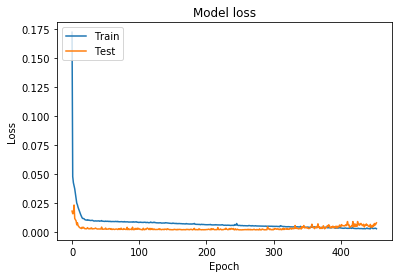

In [10]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()